In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210326-143448.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-204040.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-204543.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-205042.txt")
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-205603.txt")

In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

class MotionCalibGyrus(Gyrus):
    def __init__(self):
        self.last_pose=None
        self.last_pose_covariance=None        
        self.pose_history=[] #time, pose
        self.motor_history=[] # starttime, endtime, activity
        self.last_motor_activity=[]
        self.last_motor_activity_timestamp=[]
        
    def same_pose(self,a,b,x_thresh,t_thresh):
        delta=np.array(a)-np.array(b)
        if abs(delta[2])>t_thresh:
            return False
        dx=np.sqrt(delta[0]**2+delta[1]**2)
        if dx>x_thresh:
            return False
        return True
    
    def bracket_history(self):
        ret=[]
        pose_h=np.array(self.pose_history)
        motor_h=np.array(self.motor_history)
        indices_before=np.searchsorted(pose_h[:,0],motor_h[:,0])-1
        indices_after=np.searchsorted(pose_h[:,0],motor_h[:,0]+motor_h[:,2])
        #print(indices_before)
        valid1= indices_before>=0 
        valid2= indices_after<len(pose_h)
        #print(valid)
        indices_before=indices_before[valid1 & valid2]
        indices_after=indices_after[valid1 & valid2]
        motor_h=motor_h[valid1 & valid2]
        ret=[ [pose_h[indices_before[i]],pose_h[indices_after[i]],motor_h[i]] for i in range(len(motor_h))]
        
        turns=[]
        fbs=[]
        for r in ret:
            if r[2][0]!=0: #back forward
                turns.append(r)
            if r[2][2]!=0: #turn
                fbs.append(r)
        return {"turns":turns,"fb":fbs,"all":ret}
    
    def calibrate_fbs(self,fbs):
        x=[ fb[2][2] for fb in fbs ]

    def read_message(self,message):
        if "latest_pose" in message:
            the_pose=BayesianArray.from_object(message["latest_pose"])
            if message["pose_notes"]=="pose_is_stable":
                if len(self.pose_history)==0 or not self.same_pose(self.pose_history[-1][1].vals,the_pose.vals,0.02,0.02):
                    self.pose_history.append([message["timestamp"],the_pose]) #save to recent history for fitting
            self.last_pose=np.array(message["latest_pose"]["vals"])
            self.last_pose_covariance=np.array(message["latest_pose"]["covariance"])
        if "drive/motors_active" in message:
            motors_active=message["drive/motors_active"][0:3]
            duration=message["drive/motors_active"][3]
            if motors_active!=[0,0,0]:
                if motors_active==self.last_motor_activity:
                    self.motor_history[-1][2]+=duration                    
                else:
                    self.motor_history.append( [ message["timestamp"],message["drive/motors_active"][0:3],duration])            
            self.last_motor_activity=motors_active            
            self.last_motor_activity_timestamp=message["timestamp"]
        return []


class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.lx_dataseries=TimeSeries(title="Pose X",ylabel="X Position Lidar (m)")
        self.lx_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ly_dataseries=TimeSeries(title="Pose Y",ylabel="X Position Lidar (m)")
        self.ly_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ltheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ltheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.ctheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ctheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")   
        self.motor_durations=TimeSeries(title="Motor Duration")
        self.bfield_times=[]
        self.bfields=[]
        
        
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="lidar":
            self.lx_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][0])
            self.lx_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][0][0]))
            self.ly_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][1])
            self.ly_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][1][1]))
            self.ltheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ltheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="compass":
            self.ctheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ctheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "magnetometer/b_field" in message:
            self.bfield_times.append(message["timestamp"])
            self.bfields.append(np.array(message["magnetometer/b_field"])    )  
        if "drive/motors_active" in message:
            if message["drive/motors_active"][3]< 100:
                self.motor_durations.append(message["timestamp"],message["drive/motors_active"][3])

        return []


In [3]:
from MotionGyrus import MotionEstimationGyrus

plotters={}
plotters["pose"]=PosePlotter()

gyrii=[]
#gyrii.append(MotionEstimationGyrus(None))
mcgyrus=MotionCalibGyrus()
gyrii.append(mcgyrus)

for key in plotters:
    gyrii.append(plotters[key])

start_timestamp=sensor_log[0]["timestamp"]
inspect_messagename="none"

remove_messages=["po"]

for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                      
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            resp=g.read_message(on_message)
            if resp is not None:
                waiting_messages.extend(resp)

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


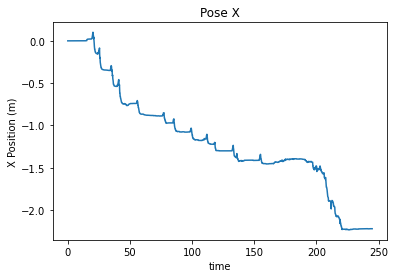

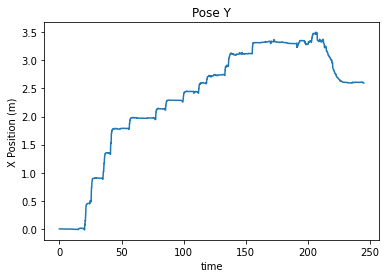

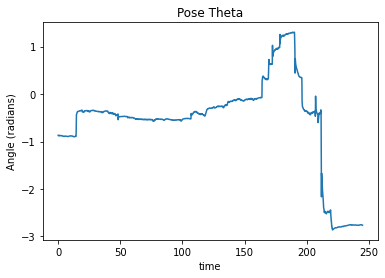

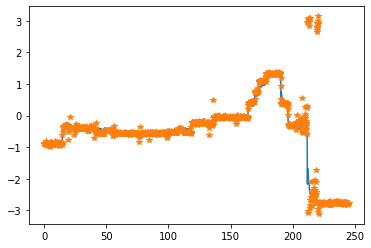

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


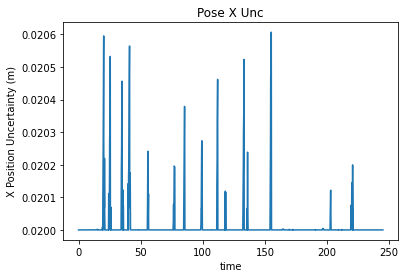

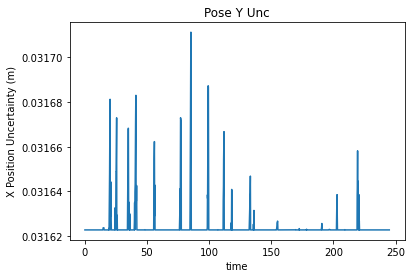

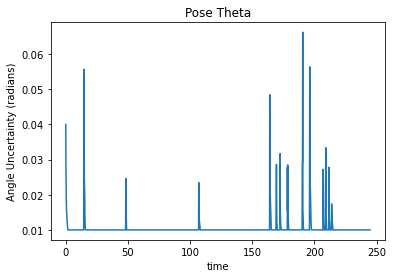

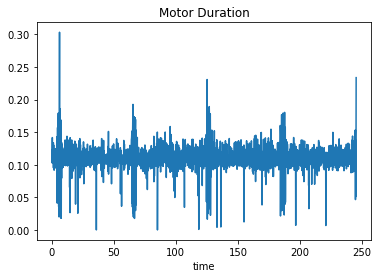

In [4]:
import matplotlib.pyplot as plt
plotters["pose"].x_dataseries.plot()
plotters["pose"].y_dataseries.plot()
plotters["pose"].theta_dataseries.plot()
plt.figure()
#plt.xlim(10,14)
plt.plot(plotters["pose"].theta_dataseries.times,plotters["pose"].theta_dataseries.data)
plt.plot(plotters["pose"].ctheta_dataseries.times,plotters["pose"].ctheta_dataseries.data,'*')
plt.show()
plotters["pose"].x_unc_dataseries.plot()
plotters["pose"].y_unc_dataseries.plot()
plotters["pose"].theta_unc_dataseries.plot()

plotters["pose"].motor_durations.plot()

45
28
28
7.52199387550354 14.458022117614746-[0, 0, -0.6] 17.364120483398438
17.364120483398438 19.242064237594604-[0.6, 0, 0] 24.377492666244507
19.433599948883057 24.092180252075195-[0.6, 0, 0] 29.117849588394165
32.0172324180603 34.21137237548828-[0.6, 0, 0] 38.994713306427
38.994713306427 39.84843134880066-[0.6, 0, 0] 45.297999143600464
45.297999143600464 48.117345094680786-[0, 0, 0.6] 50.70458507537842
50.70458507537842 55.37850832939148-[0.6, 0, 0] 59.79831528663635
68.49764633178711 76.29869961738586-[0.6, 0, 0] 80.54029607772827
80.54029607772827 84.5096070766449-[0.6, 0, 0] 88.66197991371155
91.77625107765198 98.37755155563354-[0.6, 0, 0] 102.87267541885376
102.87267541885376 106.81129717826843-[0, 0, -0.6] 110.73231363296509
110.73231363296509 111.1682870388031-[0.6, 0, 0] 115.5256175994873
116.7623393535614 117.76665544509888-[0.6, 0, 0] 121.69167017936707
127.34939384460449 132.2584297657013-[0.6, 0, 0] 140.09037375450134
132.3870940208435 135.36475777626038-[0.6, 0, 0] 140

<ipython-input-2-af5362cbd502>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  motor_h=np.array(self.motor_history)


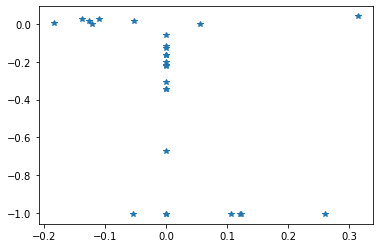

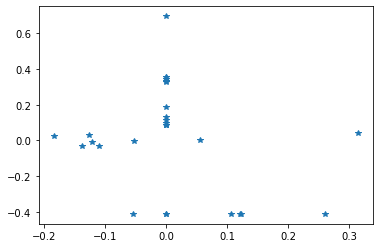

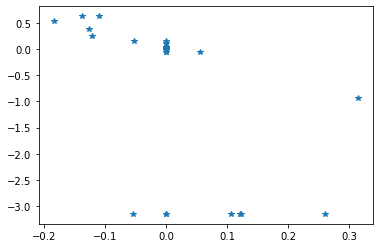

chisq is 253.667885129765
fit value is -2.291+/-0.031


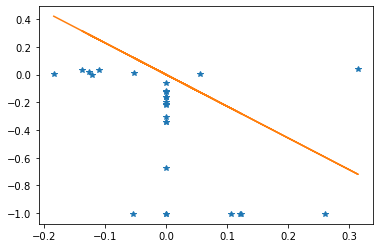

chisq is 43.886716261167926
fit value is -0.460+/-0.018


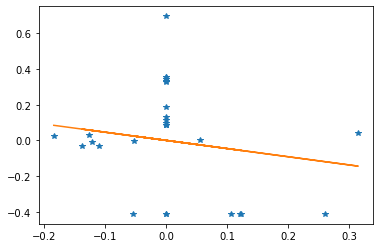

chisq is 9497.34162360977
fit value is -7.693+/-0.035


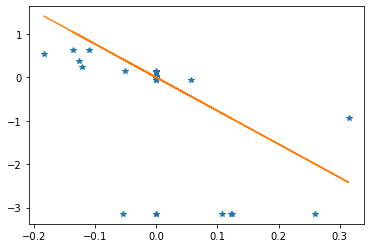

[[ 3.36342305e-03  2.48674401e-02  5.42595005e-01]
 [-3.06446547e-01  3.55985944e-01 -8.81152691e-03]
 [-6.72758901e-01  6.95919066e-01  2.47369089e-02]
 [-3.42172038e-01  3.52506503e-01  1.11983949e-02]
 [-3.43576797e-01  3.30249425e-01 -5.35933436e-02]
 [ 2.53074200e-03  2.50264572e-03 -6.16416908e-02]
 [-1.99826850e-01  1.13795962e-01 -2.30643867e-02]
 [-1.62910637e-01  9.89190264e-02  1.43320829e-02]
 [-1.64705744e-01  8.39738727e-02 -4.14531960e-03]
 [-1.62410489e-01  8.87055083e-02  3.27989889e-02]
 [ 1.37838670e-02 -5.87839333e-03  1.47014040e-01]
 [-1.17098238e-01  1.32812779e-01 -4.87090409e-02]
 [-1.25758214e-01  8.34535697e-02  1.47862510e-01]
 [-2.14503618e-01  3.43087506e-01  1.24535379e-01]
 [-2.21864007e-01  3.25249629e-01  1.20247231e-01]
 [-5.92106702e-02  1.89103382e-01  1.34626656e-03]
 [ 1.80730660e-02  2.78214363e-02  3.88929982e-01]
 [ 2.91607317e-02 -3.17324149e-02  6.25954123e-01]
 [ 2.91607317e-02 -3.17324149e-02  6.25954123e-01]
 [-2.16860525e-03 -6.84047609e-

In [5]:
from uncertainties import unumpy
from uncertainties import ufloat

print(len(mcgyrus.pose_history))
print(len(mcgyrus.motor_history))
#print(mcgyrus.pose_history)
ret=mcgyrus.bracket_history()
bh=ret["all"]
fbs=ret["fb"]
print(len(bh))
for i in range(len(bh)):
    print("{} {}-{} {}".format(bh[i][0][0],bh[i][2][0],bh[i][2][1],bh[i][1][0]))
    
def to_facing_matrix(angle):
    return np.array([[np.cos(angle),np.sin(angle),0],
                     [-np.sin(angle),np.cos(angle),0],
                     [0,0,1]]) #did I get the sign right?

def process_fb(fbs):
    ret=[]
    retuncs=[]
    for fb in fbs:
        facing=to_facing_matrix(fb[0][1].vals[2])
        #delta=fb[1][1].vals-fb[0][1].vals
        delta=fb[1][1]-fb[0][1]
        delta=delta.applymatrix(facing)
        deltau=delta.get_as_ufloat()
        ret.append(unumpy.nominal_values(deltau))
        retuncs.append(unumpy.std_devs(deltau))
        #ret.append(delta)
    return np.array(ret),np.array(retuncs)
            
#dur=[ fb[2][2] if fb[2][1][0]>0 else -fb[2][2] for fb in fbs ]
dur=[ fb[2][2]*fb[2][1][2] for fb in fbs ]
#for fb in fbs:
#    print(fb[2][1][0])


deltafs,deltafs_unc=process_fb(ret["turns"])
#deltafs,deltafs_unc=process_turns(ret["turns"])

plt.figure()
plt.plot( dur,deltafs[:,0],'*')
plt.show()
plt.figure()
plt.plot( dur,deltafs[:,1],'*')
plt.show()
plt.figure()
plt.plot( dur,deltafs[:,2],'*')
plt.show()


def fit_slope(xs,ys,sigmasquares,m_prior,m_prior_unc):
    #TODO it is trivial to include a prior on the slope here
    #given motion records and a single dimension, fit to y=m*x
    #returns best fit m, m_unc, chi-square/n
    xxsum=0
    xysum=0
    yysum=0
    prior_uncsquare=m_prior_unc**2
    #print("prior is {}".format(ufloat(m_prior,m_prior_unc)))

    for i in range(len(xs)):
        x=xs[i]
        y=ys[i]
        sigmasquare=sigmasquares[i]
        xxsum+=x*x/sigmasquare
        xysum+=x*y/sigmasquare
        yysum+=y*y/sigmasquare
    myslope=(xysum+m_prior/prior_uncsquare)/(xxsum+1/prior_uncsquare)
    #print("myslope is {}".format(myslope))
    myslope_unc=np.sqrt(1/(xxsum/sigmasquare+1/prior_uncsquare))
    #print("myslope  unc is {}".format(myslope_unc))
    chisq=myslope*myslope*xxsum-2*myslope*xysum+yysum
    chisq=chisq/len(xs)
    if chisq>1: #inflate uncertainties if I'm underestimating error bars on data
        myslope_unc*=np.sqrt(chisq)
    return myslope,myslope_unc,chisq

for i in range(3):
    m,dm,chisq=fit_slope(dur,deltafs[:,i],deltafs_unc[:,i]**2,0,1e9)
    print("chisq is {}".format(chisq))
    print("fit value is {}".format(ufloat(m,dm)))
    plt.figure()
    plt.plot( dur,deltafs[:,i],'*')
    plt.plot( dur, np.array(dur)*m)
    plt.show()

print(deltafs)